# ENHANCED: Snake Species Identification Challenge
The problem we are trying to solve here is to classify colour images of snakes, into 45 different categories (*coluber constrictor, boa imperator, crotalus horridus, ...*). The dataset we will use is extracted from the AI Crowd competition: **Snake Species Identification Challenge**. 

*For more details about out project please visit: https://www.aicrowd.com/challenges/snake-species-identification-challenge*

In this notebook, we will approach this task by implementing an **Enhanced** CNN. For this project we have also implemented a baseline approach, that also has a corresponding self-contained notebooks. 

Our motivation to tackle this problem using an enhanced approach is because the baseline appeared to be extremely overfitted. Here is a summary of the new features implemented in this enhanced model:
- Data Augmentation
- Weighted Cross-Entropy Loss 
- Regularization
- Dropout

Notebook author: **Marina Alonso**

# 1. Notebook Setting
In this section we will import Pytorch and some relevant Python libraries (Numpy, Matplotlib...) that will later be used.

In [17]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import os
import copy
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
from PIL import Image

# 2. Data Preparation

In this section we will download the original dataset, we will distribute it in training and validation, and will organize them in a structured way. 

**Dataset Download and Split:** This section has been directly executed on GCLOUD, for it is only performed once and needs some directory permissions that we do not have in the notebook. Therefore, the code is shown here as an image.
![image](https://user-images.githubusercontent.com/43316350/60433813-f9217600-9c05-11e9-9035-8fcc5fd6ee0b.png)

**Training Parameters:** We have found that the optimal batch size is of 16 images. Additionally, we set the *feature_extract* flag to False, indicating that we want to performe **fine tuning** (retrain the whole network), instead of just performing **feature extraction** (just retrain the last layer), for our dataset is quite large.

In [18]:
data_dir = "//mnt/disks/dades/"
train_data = datasets.ImageFolder('//mnt/disks/dades/train/')
num_classes = len(train_data.classes)
model_name = "densenet"  # resnet, vgg or densenet
input_size = 224  # DenseNet Characteristic
batch_size = 16
feature_extract = False

**Load Data and perform Data Augmentation and Normalization:** In this section we initialize the data transforms, image datasets, and the dataloaders, as well as normalizing the data. We also implement data augmentation, randomly selecting the forwarded crop of input size, randomly flipping horizontally the image and randomly rotating it from 0 to 90 degrees. Some documentation about Data Augmentation in Pytorch can be found at: https://pytorch.org/docs/stable/torchvision/transforms.html

In [19]:
data_dir = "//mnt/disks/dades/"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation([0, 90]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Dataset Visualization:** To get an idea of which kind of images are we dealing with, we will visualize a random mini-batch of our training data.

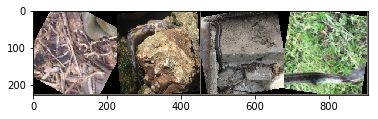

In [20]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

# Get a mini-batch of training data
mini_batch = 4
dataloaders_dict_visualize = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=mini_batch, shuffle=True, num_workers=4) for x in ['train']}
inputs, classes = next(iter(dataloaders_dict_visualize['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

# 3. Model Definition
In this section we will define the training and the initialization of the network as well as its configuration.

This notebook enables the user to choose between three network architectures: DenseNet, VGG and ResNet. However, the training is performed on **DenseNet-121** (https://arxiv.org/pdf/1608.06993.pdf), for it is the current State Of The Art Network for image classification (it obtains a 82,8% of accuracy on the ImageNet benchmark).  It was presented in 2017 CVPR where it got Best Paper Award and has more than 2000 citations. It is jointly invented by Cornwell University, Tsinghua University and Facebook AI Research (FAIR).

An interesting review of this network can be found at: https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803


**Training Definition**

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    loss_train_evo=[]
    acc_train_evo=[]
    fs_train_evo=[]
    
    loss_val_evo=[]
    acc_val_evo=[]
    fs_val_evo=[]
    
    total_train=round(47626/batch_size)

    for epoch in range(num_epochs):
        i = 0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            fscore = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    #"""
                    if i==round(0.25*total_train):
                        print('Forward Passed 25%')
                    if i==round(0.5*total_train):
                        print('Forward Passed 50%')
                    if i==round(0.75*total_train):
                        print('Forward Passed 75%')
                    i = i + 1
                    #"""
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                Fscore = f1_score(labels_cpu, predictions_cpu, average='macro')
                fscore.append(Fscore)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_fscore = np.average(np.array(fscore))
            
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_fscore))
            
            if phase == 'train':
                loss_train_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_train_evo.append(epoch_acc)
                fs_train_evo.append(epoch_fscore)                
            else:
                loss_val_evo.append(epoch_loss)
                epoch_acc = epoch_acc.cpu().numpy()
                acc_val_evo.append(epoch_acc)
                fs_val_evo.append(epoch_fscore) 
                
            # deep copy the model
            if phase == 'valid' and epoch_fscore > best_fscore:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train_evo, acc_train_evo, fs_train_evo, loss_val_evo, acc_val_evo, fs_val_evo

# sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

**Model Initialization with Dropout:** We randomly pick  some nodes in a layer to be dropped/ignored during training.
It forces the learning algorithm to spread the out the weights and not focus on some specific features.

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":  # ResNet-50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":  # VGG-11
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":  # DenseNet-121
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        # DROPOUT
        model_ft.features.denseblock4.denselayer8.relu2 = nn.Sequential(
            nn.Dropout2d(0.15),
            nn.ReLU(inplace=True)
        )
        model_ft.features.denseblock4.denselayer16.relu2 = nn.Sequential(
            nn.Dropout2d(0.15),
            nn.ReLU(inplace=True)
        )
        model_ft.classifier = nn.Sequential(
            nn.Dropout2d(0.5),
            nn.Linear(num_ftrs,num_classes)
        )
        input_size = 224

    return model_ft, input_size

**Model Initialization and Configuration:** For this enhanced version, whe chose **WEIGHTED Cross-Entropy Loss** as the training loss and the **ADAM optimizer** - a combination of Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp) - with a static learning rate for backpropagation. Each class has a weight assiociated corresponding to the inverse of its frequency in the dataset.

As we are working on a classification task, we have chosen to use the Cross Entropy Loss. For the optimizer we will use Adaptive Moments - **ADAM** (having previously seen that it gives better results than the Gradient Descent, where the network got stuck very often). 

To prevent the overfitting that appeared on our model, we decided to implement **loss regularization**, though we could have used many other techniques such as early stopping, dropout, or data augmentation among others. We decided to add the L2 Regularization (or weight decay) to our cross-entropy loss. The L2 penalizes the complexity of the classifier by measuring the number of zeros in the weight vector. The resulting total loss is the following. 

In [23]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            a=1 # print("\t",name)
            
# Optimizer
optimizer_ft = optim.Adam(params_to_update, lr=3e-4, weight_decay=0.001)

# Loss Funciton
weights=[]
for c in os.listdir('/mnt/disks/dades/train'):
    train_dir=os.path.join('/mnt/disks/dades/train',c)
    weights.append(len(os.listdir(train_dir)))
weights = [sum(weights) / x for x in weights]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 4. Model Fine-Tuning 

**Training and Validation:** Network is trained for a 30 epochs on GCLOUD. The initial idea was to fine tune the model on this Jupyter Notebook. However, due to its wrong memory management, sometimes the training stopped after a few epochs and model did not end its training. Therefore, model has been directly run on GCLOUD terminal and then its metrics printed and hardcoded on this notebook to be able to visualize them. Although we are aware that this is not an elegant solution, we use it because it has shown to be effective. 

*Here, a training sample of two epochs is followingly shown*.  

In [ ]:
num_epochs = 2
model_ft, loss_train, acc_train, fs_train, loss_val, acc_val, fs_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
# Save model
# torch.save(model_ft.state_dict(),'/mnt/disks/dades/model_baseline.pth')

Epoch 1/3
Forward Passed 25%
Forward Passed 50%
Forward Passed 75%
train Loss: 2.2601 Acc: 0.2827 F: 0.152
valid Loss: 1.8405 Acc: 0.3674 F: 0.221
Epoch 2/3


**Metrics Evolution Visualization:** We consider the loss, the accuracy and the f1 score to be the three most relevant metrics for our task. In order to visualize their evolution, we define a function that compares its training values with its validation ones.  

In [7]:
def plot_metric(metric_train, metric_val, title):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle(title)
    ax.set(xlabel='epoch')
    ax.plot(metric_train, label='Training')
    ax.plot(metric_val, label='Validation')
    ax.legend(loc='upper left')

# Results for a GCLOUD Terminal training for 30 epochs

loss_train = [2.0797, 1.6595, 1.5330, 1.4616, 1.4026, 1.3728, 1.1890, 1.1218, 1.0966, 1.0701, 1.0508, 1.0374, 1.0166, 0.9972, 0.9983, 0.9909, 0.9891, 0.9838, 0.9786, 0.9845, 0.9800, 0.9757, 0.9689, 0.9793, 0.9785, 0.9742, 0.9748, 0.9732, 0.9737, 0.9707]
loss_val =  [1.5348, 1.3393, 1.2638, 1.2510, 1.1754, 1.2171, 1.0229, 0.9836, 0.9760, 0.9803, 0.9524, 0.9489, 0.9510, 0.9292, 0.9181, 0.9262, 0.9258, 0.9266, 0.9164, 0.9195, 0.9263, 0.9224, 0.9124, 0.9153, 0.9144, 0.9160, 0.9231, 0.9185, 0.9238, 0.9279]

acc_train = [0.3263, 0.4262, 0.4667, 0.4868, 0.5048, 0.5165, 0.5662, 0.5880, 0.6020, 0.6077, 0.6146, 0.6155, 0.6254, 0.6300, 0.6297, 0.6303, 0.6321, 0.6366, 0.6365, 0.6331, 0.6343, 0.6371, 0.6363, 0.6360, 0.6385, 0.6372, 0.6365, 0.6391, 0.6373, 0.6377]
acc_val = [0.4504, 0.5150, 0.5296, 0.5321, 0.5644, 0.5484, 0.6160, 0.6264, 0.6291, 0.6339, 0.6418, 0.6438, 0.6408, 0.6493, 0.6528, 0.6551, 0.6529, 0.6537, 0.6525, 0.6568, 0.6504, 0.6538, 0.6522, 0.6571, 0.6564, 0.6563, 0.6572, 0.6567, 0.6563, 0.6557]

fs_train = [0.187 , 0.279 , 0.317 , 0.338 , 0.355 , 0.367 , 0.418 , 0.441 , 0.455 , 0.461 , 0.467, 0.469, 0.478, 0.486, 0.486, 0.486, 0.488, 0.492, 0.493, 0.488, 0.491, 0.493, 0.493, 0.492, 0.495, 0.493, 0.492, 0.496, 0.493, 0.495]
fs_val = [0.293 , 0.354 , 0.371 , 0.377 , 0.410 , 0.392 , 0.463 , 0.473 , 0.478 , 0.485, 0.490, 0.493, 0.491, 0.498, 0.505, 0.503, 0.501, 0.503, 0.506, 0.507, 0.501, 0.505, 0.503, 0.508, 0.504, 0.509, 0.509, 0.506, 0.510, 0.507]

plot_metric(loss_train, loss_val, 'Loss')
plot_metric(acc_train, acc_val, 'Accuracy')
plot_metric(fs_train, fs_val, 'F-Score')

SyntaxError: invalid character in identifier (<ipython-input-7-c03395c3afc6>, line 16)

# 5. Testing

**Model Loading:** We load our previously saved model to perform a test inference. This loading is necessary if we have not run the training on the Jupyter Notebook, for in this case we will not have the model saved in our current memory. 

In [10]:
# Load pretrained model 
model_weights_path = '/mnt/disks/dades/model_baseline.pth'
model_weights = torch.load(model_weights_path)
model_ft.load_state_dict(model_weights)
print('Model Loaded')

Model Loaded


**Infer Test Data:** We infer to our model a random image from the test set and visualize it with its predicted class. We do not have the test set labels, for we cannot evaluate our model's behaviour on this particular image. However, an interesting option is to look for the predicted class in Google Images and see if the images shown are similar to the one infered to our network...

Predicted class:  Crotalus Pyrrhus


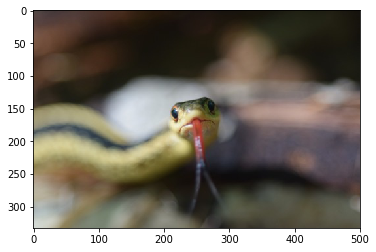

In [11]:
def get_item():
    test_files = os.listdir('/mnt/disks/dades/test/')
    idx = random.randint(0,len(test_files))
    ima_dir = os.path.join('/mnt/disks/dades/test/',test_files[idx])
    scaler = transforms.Resize((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()
    ima = Image.open(ima_dir)
    plt.imshow(ima)
    item = (normalize(to_tensor(scaler(ima))).unsqueeze(0)).to(device)
    return item

class_name = ['Thamnophis Proximus', 'Nerodia Sipedon', 'Opheodrys Vernalis', 'Crotalus Horridus', 'Crotalus Pyrrhus', 'Nerodia Rhombifer', 'Thamnophis Sirtalis', 'Natrix Natrix', 'Crotalus Adamanteus', 'Charina Bottae', 'Pituophis Catenifer', 'Lampropeltis Triangulum', 'Nerodia Erythrogaster', 'Thamnophis Marcianus', 'Lampropeltis Californiae', 'Crotalus Ruber', 'Rhinocheilus Lecontei', 'Opheodrys Aestivus', 'Thamnophis Ordinoides', 'Thamnophis Radix', 'Masticophis Flagellum', 'Pantherophis Vulpinus', 'Hierophis Viridiflavus', 'Feterodon Platirhinos', 'Pantherophis Emoryi', 'Regina Septemvittata', 'Haldea Striatula', 'Diadophis Punctatus', 'Nerodia Fasciata', 'Storeria Occipitomaculata', 'Crotalus Scutulatus', 'Storeria Dekayi', 'Crotalus Viridis', 'Boa Imperator', 'Pantherophis Obsoletus', 'Lichanura Trivirgata', 'Agkistrodon Contortrix', 'Thamnophis Elegans', 'Agkistrodon Piscivorus', 'Pantherophis Guttatus', 'Crotalus Atrox', 'Carphophism Amoenus', 'Coluber Constrictor', 'Pantherophis Spiloides', 'Pantherophis Alleghaniensis']
item = get_item()
model_ft.eval()
output = model_ft(item)
_, preds = torch.max(output, 1)
class_id = preds.item()
print("Predicted class: ", class_name[class_id])

## 6. Conclusions

We concluded that our enhanced network performed decently on the task of snakes species identification with just a few epochs, reaching an maximum accuracy of 65.75% on the validation set. Additionally, it is not overfitted, for it manages to generalize well. We assume that with some hyperparameter corrections, results would improve a lot. 